# MHKiT Environmental Contours

Environmental contours describing extreme sea states can be used for numerical or physical model simulations analyzing the design-response of WECs. MHKiT includes functions adapted from the [WDRT](https://github.com/WEC-Sim/WDRT) for creating environmental contours of extreme sea states using a principle components analysis (PCA) methodology with additional improvements for characterizing the joint probability distribution of sea state variables of interest. These environmental contours, characterized by combinations of significant wave height (Hm0) and energy period (Te) or peak period (Tp), provide inputs that are associated with a certain reliability interval. These reliability levels are needed to drive both contour and full sea state style long-term extreme response analyses. This notebook will walk through the following steps to find a 100 year contour for NDBC buoy 46022.

 1. Request Spectral Wave Density Data from NDBC
 2. Calculate Hm0 and Te using the requested data
 3. Find the data's 100-year contour
 4. Plot the data and the 100-year contour

We will start by importing the necessary python packages (`scipy`, `pandas`, `numpy`) and MHKiT wave submodules (`resource`, `graphics`, and `io.ndbc`).

In [1]:
from mhkit.wave import resource, graphics
import matplotlib.pyplot as plt
from mhkit.wave.io import ndbc
from scipy import stats
import pandas as pd
import numpy as np

## 1. Request Spectral Wave Density Data from NDBC
   
MHKiT can be used to request historical data from the National Data Buoy Center ([NDBC](https://www.ndbc.noaa.gov/)). This process is split into 2 steps where:

 1. The user requests the available data for a given parameter and optionally a buoy number. 
 2. The user passes the desired filenames from the available data
 
Looking at the help for the `available_data` function (e.g. `help(ndbc.available_data)`) the function requires a parameter to be specified (e.g `'swden'`) and optionally the user may provide a station ID as a string. he environmental contour we are interested in historical data `'swden'` and we will specify the buoy number as `'46022'`.

In [2]:
# Specify the parameter as spectral wave density and the buoy number to be 46022
spectral_wave_density='swden'
buoy_number = '46022' 
available_data= ndbc.available_data(spectral_wave_density, buoy_number)
available_data.tail()

,id,year,filename
1434,46022,2016,46022w2016.txt.gz
1435,46022,2017,46022w2017.txt.gz
1436,46022,2018,46022w2018.txt.gz
1437,46022,2019,46022w2019.txt.gz
1438,46022,2004,46022wb2004.txt.gz


### Select years of interest
The `ndbc.available_data` function has returned a DataFrame with columns 'id', 'year', and 'filename'. The year column is of type int and the id (5 digit alpha-numeric specifier) and filename are of type string. In this case the years returned from available_data span 1996 to the last complete year the buoy was operational (currently 2019 for 46022). For demonstration we have decided we are interested in the data between years 1996 and 2012 so we will create a new DataFrame which only contains years less than 2013.  

In [3]:
# Slice the DataFrame on years of interest
yearsOfInterest = available_data[available_data.year < 2013]
yearsOfInterest.tail()

,id,year,filename
1427,46022,2009,46022w2009.txt.gz
1428,46022,2010,46022w2010.txt.gz
1429,46022,2011,46022w2011.txt.gz
1430,46022,2012,46022w2012.txt.gz
1438,46022,2004,46022wb2004.txt.gz


### Request the Data
The filename in our DataFrame and the parameter is needed to request the data. The `ndbc.request_data` function will iterate over each buoy, and year to return the parameter data as a DataFrame.  Lastly, we can convert the NDBC time columns to DateTime and set this as the index for each DataFrame by looping over the years.
With the data Using the filenames from our `yearsOfInterest` we can request data from NDC and return a dictionary of DataFrames indexed by years.

In [4]:
# Get dictionary of parameter data by year
filenames= yearsOfInterest['filename']
ndbc_data = ndbc.request_data(spectral_wave_density, filenames)

# Lastly we will convert a DateTime Index 
mhkit_data={}
# Create a Datetime Index and remove NOAA date columns for each year
for year in ndbc_data:
   year_data = ndbc_data[year]
   year_data['date'], ndbc_date_cols = ndbc.dates_to_datetime(spectral_wave_density, 
                                                              year_data, 
                                                              return_date_cols=True)
   year_data = year_data.drop(ndbc_date_cols, axis=1)
   year_data = year_data.set_index('date')
   # Convert columns to float now that the ndbc_date_cols (type=str) are gone
   year_data.columns = year_data.columns.astype(float)     
   mhkit_data[year] = year_data

## 2. Calculate Hm0 and Te using the NDBC Data
We can now use MHKiT to calculate Hm0 and Te for each year and then combine the resultant metrics into a single DataFrame. 

In [11]:
# Intialize empty lists to store the results from each year
Hm0_list=[]
Te_list=[]

# Iterate over each year and save the result in the initalized dictionary
for year in mhkit_data:
    year_data = mhkit_data[year]
    Hm0_list.append(resource.significant_wave_height(year_data.T))
    Te_list.append(resource.energy_period(year_data.T))

# Concatenate list of Series into a single DataFrame
Te     = pd.concat(Te_list ,axis=0)
Hm0_Te = pd.concat(Hm0_list ,axis=0)
Hm0_Te['Te'] = Te.Te

# Drop any NaNs created from the calculation of Hm0 or Te
Hm0_Te.dropna(inplace=True)
# Sort the DateTime index
Hm0_Te.sort_index(inplace=True)
Hm0_Te

,Hm0,Te
date,,
1996-01-01 00:00:00,4.819627,14.856398
1996-01-01 01:00:00,5.004158,14.961679
1996-01-01 02:00:00,5.091169,14.244618
1996-01-01 03:00:00,4.679487,14.042246
1996-01-01 04:00:00,5.140895,14.478961
...,...,...
2012-12-31 19:00:00,1.995194,14.757854
2012-12-31 20:00:00,1.976259,14.360242
2012-12-31 21:00:00,2.658421,15.708162


## 3. Find the contour line for the 100 year
We can now apply the environmental contours function to find the expected 100-year sea-state. In addition to the sea state value (Hm0, Te) we need to specify the time difference between measurements (dt in seconds) and specify the contour year of interest (e.g. 100 years).

In [14]:
# Return periods (yrs) of interest
contour_year = 100  

# Remove Outliers
Hm0_Te_clean = Hm0_Te[Hm0_Te.Hm0 < 20]

# Get only the values from the DataFrame
Hm0 = Hm0_Te_clean.Hm0.values  
Te  = Hm0_Te_clean.Te.values 

# Delta time of sea-states 
dt = (Hm0_Te_clean.index[2]-Hm0_Te_clean.index[1]).seconds  

# Get the contour values
Hm0_contour, Te_contour = resource.environmental_contour(Hm0, Te, dt, contour_year)

## 4. Plot overlay of the data and contour
Lastly we can use the MHKiT graphics module to create a contour plot which shows the data and resultant conotour line

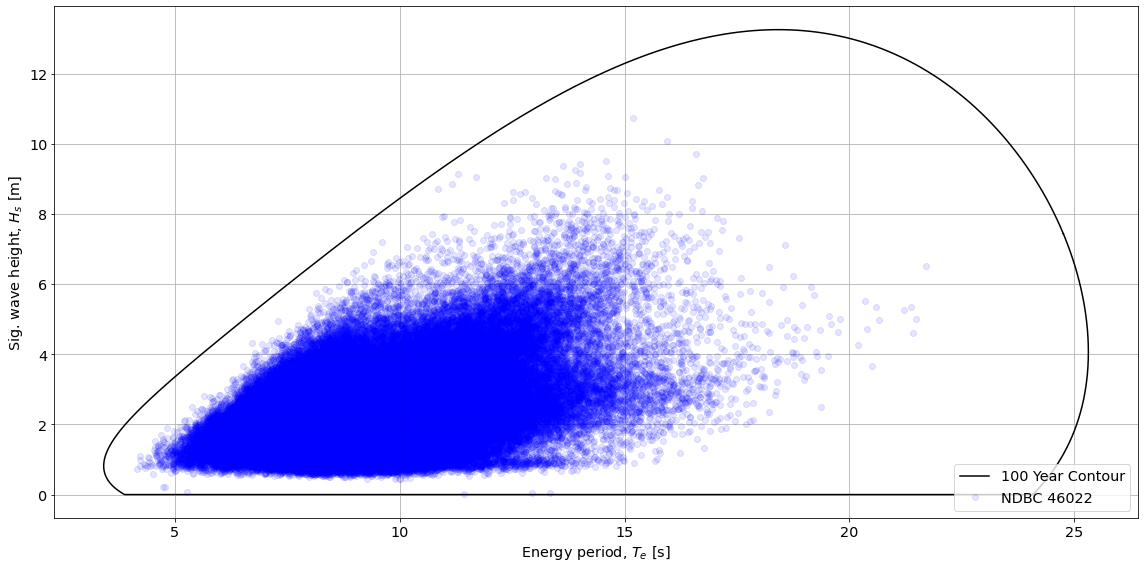

In [16]:
graphics.plot_environmental_contour(Hm0, Te, 
                                    Hm0_contour, Te_contour, 
                                    data_label='NDBC 46022', 
                                    contour_label='100 Year Contour')